In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [169]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\OLUWASEUN ADEGOROYE\.labelmerc


In [31]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [32]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [33]:
tf.config.list_physical_devices('GPU')

[]

In [163]:
images = tf.data.Dataset.list_files(r'C:\Users\OLUWASEUN ADEGOROYE\Downloads\archive (3)\Eye_diseases')

In [164]:
images.as_numpy_iterator().next()

b'C:\\Users\\OLUWASEUN ADEGOROYE\\Downloads\\archive (3)\\Eye_diseases'

In [165]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [166]:
images = images.map(load_image)

In [167]:
images.as_numpy_iterator().next()

UnknownError: NewRandomAccessFile failed to Create/Open: C:\Users\OLUWASEUN ADEGOROYE\Downloads\archive (3)\Eye_diseases : Access is denied.
; Input/output error
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

In [168]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [42]:
image_generator = images.batch(4).as_numpy_iterator()

In [43]:
plot_images = image_generator.next()

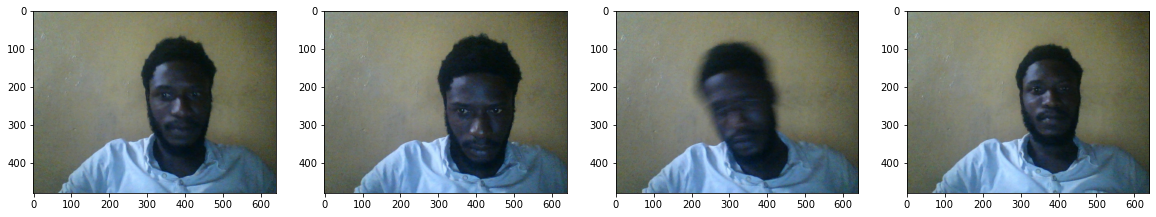

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [45]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

In [46]:
import albumentations as alb

In [47]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [50]:
img = cv2.imread(os.path.join('data','train', 'images','00bdb2b8-cda6-11ec-b7e0-204747b6bbdd.jpg'))

In [51]:
img.shape

(480, 640, 3)

In [52]:
with open(os.path.join('data', 'train', 'labels', '00bdb2b8-cda6-11ec-b7e0-204747b6bbdd.json'), 'r') as f:
    label = json.load(f)

In [53]:
label['shapes'][0]['points']

[[281.09523809523813, 53.14285714285717],
 [590.6190476190476, 365.04761904761904]]

In [54]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [55]:
coords = list(np.divide(coords, [640,480,640,480]))

In [56]:
coords

[0.4392113095238096,
 0.11071428571428577,
 0.9228422619047618,
 0.760515873015873]

In [57]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Emma'])

In [58]:
augmented['bboxes'][0][2:]

(0.5864550264550263, 0.8001058201058201)

In [59]:
augmented['bboxes']

[(0.0, 0.10698412698412704, 0.5864550264550263, 0.8001058201058201)]

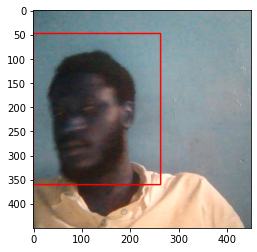

In [60]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [62]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['Emma'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [63]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [64]:
train_images.as_numpy_iterator().next()

array([[[0.2853554 , 0.4966299 , 0.2461397 ],
        [0.30992648, 0.49944854, 0.29718137],
        [0.5801471 , 0.81464463, 0.63572305],
        ...,
        [0.18321079, 0.46017158, 0.31409314],
        [0.18449755, 0.48939952, 0.33694854],
        [0.18088235, 0.4798407 , 0.3268995 ]],

       [[0.30030638, 0.50147057, 0.25079656],
        [0.31924018, 0.5119485 , 0.25741422],
        [0.36096814, 0.5851716 , 0.3567402 ],
        ...,
        [0.18033089, 0.4745098 , 0.3230392 ],
        [0.17598039, 0.48137254, 0.32990196],
        [0.1973652 , 0.4852941 , 0.33835784]],

       [[0.3148897 , 0.51979166, 0.25030637],
        [0.31427696, 0.50392157, 0.2598652 ],
        [0.3033701 , 0.5110907 , 0.29656863],
        ...,
        [0.16550244, 0.4670343 , 0.33284312],
        [0.17254902, 0.4745098 , 0.3420343 ],
        [0.18645833, 0.4766544 , 0.34430146]],

       ...,

       [[0.49987745, 0.6898897 , 0.38192403],
        [0.5077206 , 0.67634803, 0.3939951 ],
        [0.49240196, 0

In [65]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        z
    return [label['class']], label['bbox']

In [66]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [67]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2128, 0.1434, 1.    , 0.868 ], dtype=float16))

In [68]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3840, 3840, 720, 720, 840, 840)

In [69]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [70]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [71]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [72]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4082 , 0.1017 , 1.     , 0.874  ],
        [0.     , 0.10474, 0.6797 , 0.8823 ],
        [0.     , 0.1213 , 0.5303 , 0.9414 ],
        [0.2379 , 0.1393 , 0.8887 , 0.806  ],
        [0.1276 , 0.1528 , 0.7837 , 0.867  ],
        [0.459  , 0.0906 , 1.     , 0.8896 ],
        [0.     , 0.1733 , 0.3953 , 0.9565 ],
        [0.2576 , 0.1135 , 0.903  , 0.9336 ]], dtype=float16))

In [73]:
data_samples = train.as_numpy_iterator()

In [74]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


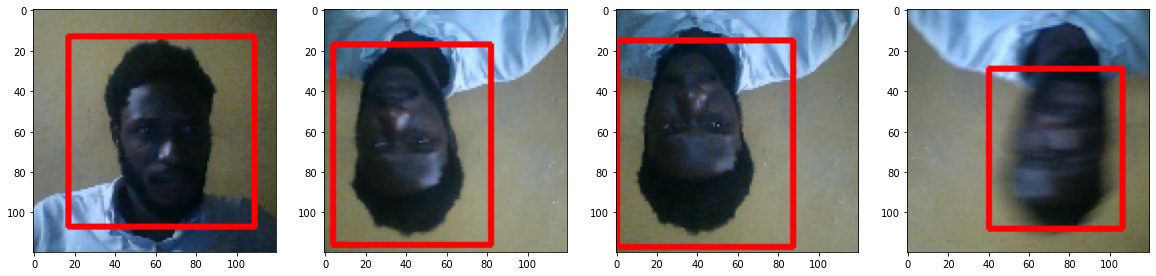

In [75]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [132]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [133]:
vgg = VGG16(include_top=False)

In [134]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [135]:
facetracker = build_model()

In [136]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_10[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_4 (GlobalM (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_5 (GlobalM (None, 512)          0           vgg16[0][0]                      
____________________________________________________________________________________________

In [137]:
X, y = train.as_numpy_iterator().next()

In [138]:
X.shape

(8, 120, 120, 3)

In [139]:
classes, coords = facetracker.predict(X)

In [140]:
classes, coords

(array([[0.62158346],
        [0.6168927 ],
        [0.5752574 ],
        [0.5545386 ],
        [0.579112  ],
        [0.6329416 ],
        [0.57582176],
        [0.6298896 ]], dtype=float32),
 array([[0.5406324 , 0.36303246, 0.48708484, 0.4640675 ],
        [0.61616546, 0.3143229 , 0.51038384, 0.52106875],
        [0.47734916, 0.47326365, 0.46911794, 0.50908023],
        [0.48911485, 0.4163375 , 0.504315  , 0.5096787 ],
        [0.6272465 , 0.33267224, 0.49966124, 0.51961416],
        [0.4948359 , 0.47875527, 0.5148962 , 0.46581864],
        [0.55156714, 0.40004584, 0.4409029 , 0.46621367],
        [0.5789229 , 0.37052292, 0.39644152, 0.47465333]], dtype=float32))

In [141]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [142]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [143]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [144]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [145]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.825987>

In [146]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5148631>

In [147]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.825987>

In [148]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
model = FaceTracker(facetracker)


In [149]:
model.compile(opt, classloss, regressloss)

In [150]:
logdir='logs'

In [151]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [152]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
480/480 [==============================] - 1574s 3s/step - total_loss: 0.2722 - class_loss: 0.0276 - regress_loss: 0.2584 - val_total_loss: 0.0629 - val_class_loss: 1.1776e-04 - val_regress_loss: 0.0629
Epoch 2/10
480/480 [==============================] - 1701s 4s/step - total_loss: 0.1474 - class_loss: 0.0167 - regress_loss: 0.1390 - val_total_loss: 0.1829 - val_class_loss: 6.9566e-04 - val_regress_loss: 0.1825
Epoch 3/10
480/480 [==============================] - 1743s 4s/step - total_loss: 0.1111 - class_loss: 0.0117 - regress_loss: 0.1052 - val_total_loss: 0.0623 - val_class_loss: 0.0043 - val_regress_loss: 0.0601
Epoch 4/10
480/480 [==============================] - 1797s 4s/step - total_loss: 0.0889 - class_loss: 0.0081 - regress_loss: 0.0849 - val_total_loss: 0.1096 - val_class_loss: 1.8722e-04 - val_regress_loss: 0.1095
Epoch 5/10
480/480 [==============================] - 1744s 4s/step - total_loss: 0.0821 - class_loss: 0.0094 - regress_loss: 0.0774 - val_total_los

KeyboardInterrupt: 

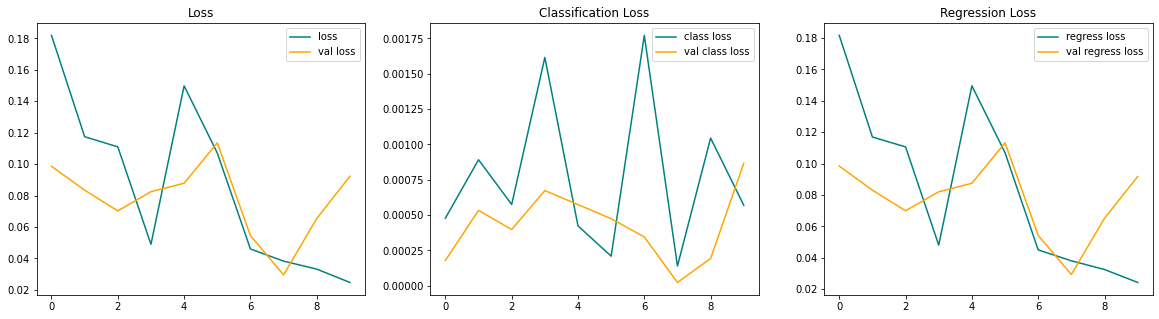

In [153]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [154]:
test_data = test.as_numpy_iterator()

In [155]:
test_sample = test_data.next()

In [156]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


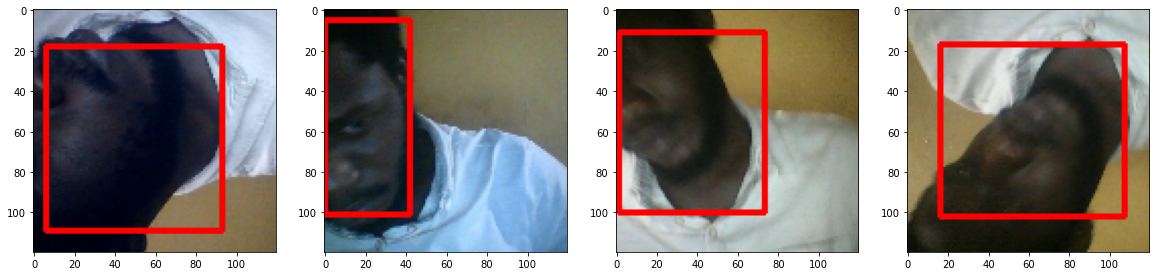

In [157]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [158]:
from tensorflow.keras.models import load_model

In [159]:
facetracker.save('facetracker.h5')

In [160]:
facetracker = load_model('facetracker.h5')

In [161]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Emma', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
 